Criamos duas classes em Python para extrair e trabalhar os valores dos pixels extraídos das texturas selecionadas para representar cada categoria de imagem.
A classe ***channelsSets()*** pode ser iniciada sem nenhum parâmetro e desta forma irá ler cada um dos sets de imagem e extrair os dados dos pixeis.
Se iniciada com um endereço para um arquivo, irá ler os dados já extraídos do respectivo arquivo como fizemos no caso abaixo, em que: os dados já foram extraídos e estão salvos em '*http://hyphae.top/dataset/setcolors2.json*' no formato json como um dicionário.

In [ ]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import requests

class channelsFromSet: # Essa classe será invocada pela próxima classe ao ser iniciada.
    def __init__(self, set_, setName=False): # incia a classe em Python recebendo como parâmetro de entrada uma string ou uma lista de string com as chaves de self.translate
        self.root = '[caminho_para_a_pasta]/imgsat/' # *** CERTIFICAR QUE ESTÁ COM O ENDEREÇO CORRETO !! ***
        self.translate = { # traduz o nome (string) do parâmetro de entrada set para um código numérico
            'floresta': 1, 'água': 2, 'estrada': 3, 'construção': 4,
            'pasto': 5, 'plantação': 6, 'eucalipto': 7
        }
        if isinstance(set_, dict):
            self.name = setName
            self.data = set_
        else:
            self.set = set_
            self.data = { # os dados que seram coletados pela operação
                'index': list(range(0, 256)),
                'R': [0] * 256, # o índice destas listas são o valor de um canal de cor (R, G ou B) de 0 a 255, o valor a a quantidade de pixels com esse valor
                'G': [0] * 256,
                'B': [0] * 256,
                'R_med': [], # Essas são listas das médias de um canal em cada uma das imagens
                'G_med': [],
                'B_med': [],
                'img_count': 0, # O número de imagens acessadas
                'pixel_count': 0, # O número de pixels acessados
                'images': []
            }
            if isinstance(set_, list): # se set_ for uma lista de strings
                self.name = ', '.join(set_)
                for n in set_: # para cada string em set_
                    if n not in self.translate:
                        raise ValueError("O valor '"+n+"' não foi encontrado.")
                    self.dataFromFolder(self.formatFolderName(self.translate[n])) # extrai dados para cada arquivo da seguinte pasta
            else: # se set for apenas uma string
                self.name = set_
                if set_ not in self.translate:
                    raise ValueError(f"O valor '"+set_+"' não foi encontrado.")
                self.dataFromFolder(self.formatFolderName(self.translate[set_])) # extrai dados para cada arquivo da seguinte pasta
            self.data['R_med'].sort()
            self.data['G_med'].sort()
            self.data['B_med'].sort()

    def dataFromFile(self, file): # extrai os dados de um arquivo de imagem
        img = Image.open(file)
        pixels = list(img.getdata())

        total_R, total_G, total_B = 0, 0, 0
        file_data = {
            'R': [0] * 256, # o índice destas listas são o valor de um canal de cor (R, G ou B) de 0 a 255, o valor a a quantidade de pixels com esse valor
            'G': [0] * 256,
            'B': [0] * 256
        }

        for pixel in pixels:
            R, G, B = pixel
            self.data['R'][R] += 1
            self.data['G'][G] += 1
            self.data['B'][B] += 1
            file_data['R'][R] += 1
            file_data['G'][G] += 1
            file_data['B'][B] += 1

            total_R += R
            total_G += G
            total_B += B
            self.data['pixel_count'] += 1

        R_med = total_R / len(pixels)
        G_med = total_G / len(pixels)
        B_med = total_B / len(pixels)

        file_data['R_med'] = R_med
        file_data['G_med'] = G_med
        file_data['B_med'] = B_med

        self.data['R_med'].append(R_med)
        self.data['G_med'].append(G_med)
        self.data['B_med'].append(B_med)
        self.data['img_count'] += 1
        return file_data

    def dataFromFolder(self, folder): # extrai  os dados de todos os arquivos de uma pasta
        files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
        for file in files:
            tmp=self.dataFromFile(os.path.join(folder, file))
            tmp['file'] = file
            self.data['images'].append(tmp)

    def formatFolderName(self, code): # tranforma o código em um nome de um diretório
        format_str = f"{code:08}"
        return os.path.join(self.root, format_str)

    def plotData(self, des=False):
        # Convertendo os dados para um DataFrame e calculando as percentagens
        total_pixels = self.data['pixel_count']
        df = pd.DataFrame({
            'R': (np.array(self.data['R']) / total_pixels) * 100,
            'G': (np.array(self.data['G']) / total_pixels) * 100,
            'B': (np.array(self.data['B']) / total_pixels) * 100
        })

        # Calculando os histogramas e convertendo para percentagem
        r_hist, r_bins = np.histogram(self.data['R_med'], bins=64, range=(0, 256))
        r_hist = (r_hist / len(self.data['R_med'])) * 100

        g_hist, g_bins = np.histogram(self.data['G_med'], bins=64, range=(0, 256))
        g_hist = (g_hist / len(self.data['G_med'])) * 100

        b_hist, b_bins = np.histogram(self.data['B_med'], bins=64, range=(0, 256))
        b_hist = (b_hist / len(self.data['B_med'])) * 100

        # Encontrando o valor máximo de percentagem para definir a escala do eixo y
        max_percent = max(df['R'].max(), df['G'].max(), df['B'].max(), r_hist.max(), g_hist.max(), b_hist.max())

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

        # Plotando o canal R
        df['R'].plot(kind='bar', ax=axes[0], title='Red Channel', color='gray')
        axes[0].plot(r_bins[:-1], r_hist, color='red')
        axes[0].set_ylim(0, max_percent)
        axes[0].set_ylabel('%')
        axes[0].xaxis.set_ticks(np.arange(0, 257, 32))

        # Plotando o canal G
        df['G'].plot(kind='bar', ax=axes[1], title='Green Channel', color='gray')
        axes[1].plot(g_bins[:-1], g_hist, color='green')
        axes[1].set_ylim(0, max_percent)
        axes[1].set_ylabel('%')
        axes[1].xaxis.set_ticks(np.arange(0, 257, 32))

        # Plotando o canal B
        df['B'].plot(kind='bar', ax=axes[2], title='Blue Channel', color='gray')
        axes[2].plot(b_bins[:-1], b_hist, color='blue')
        axes[2].set_ylim(0, max_percent)
        axes[2].set_ylabel('%')
        axes[2].xaxis.set_ticks(np.arange(0, 257, 32))

        # Descrição dos dados, se pedido
        def compute_stats(data):
            total = sum(data)
            indices = np.arange(len(data))
            mean = np.sum(indices * data) / total
            variance = np.sum(data * (indices - mean)**2) / total
            std = np.sqrt(variance)
            probabilities = data / total
            entropy = -np.sum(probabilities * np.log2(probabilities + np.finfo(float).eps))
            mode = np.argmax(data)
            min_val = next((i for i, x in enumerate(data) if x), 0)
            max_val = max(indices)

            # Cálculo da mediana
            cumulative = np.cumsum(data)
            median_idx = np.where(cumulative >= total / 2)[0][0]

            return {
                'Min': min_val,
                'Max': max_val,
                'Moda': mode,
                'Mediana': median_idx,
                'Média': mean,
                'Variância': variance,
                'Desvio Padrão': std,
                'Distribuição': entropy
            }

        if des:
            for idx, color in enumerate(['R', 'G', 'B']):
                stats = compute_stats(np.array(self.data[color]))
                desc = "\n".join([f"{key}: {value:.2f}" for key, value in stats.items()])
                axes[idx].text(0.95, 0.95, desc, transform=axes[idx].transAxes, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # Mostrando a quantidade de imagens e pixels
        plt.figtext(0.5, -0.05, f"{self.data['img_count']:,} imagens e {self.data['pixel_count']:,} pixels", ha="center", fontsize=12)

        plt.tight_layout()
        plt.show()

    def __str__(self): # o retorno se fizer um print desta classe
        return f"Data from: {self.name}; Input images: {self.data['img_count']:,}; Input pixels: {self.data['pixel_count']:,}\nself.data index:\n   'R', 'G' e 'B': O index é o valor de 0 a 255 do canal em um pixel, o valor é o número de pixels com este valor.\n   'R_med', 'G_med', 'B_med': Lista de médias dos canais em cada imagem, ordenada do menor para o maior.\n   'img_count': Número de imagens acessadas.\n   'pixel_count': Número de pixels acessados."

class channelsSets: # Inicie a classe sem parâmetros para ler os dados direto das imagens, ou inicie com o endereço do arquivo de dados para lê-lo.
    def __init__(self, file=False):
        self.file=file
        self.sets= ['floresta', 'água', 'estrada', 'construção', 'pasto', 'plantação', 'eucalipto']
        if not file:
            self.data= {}
            for set in self.sets:
                self.data[set]=channelsFromSet(set)
        else:
            self.open(file)

    def setFile(self, file):
        self.file=file

    def save(self, file=False):
        if file:
            self.file=file
        # Convertendo o class channelsFromSet em um dictionary
        data={}
        for n in self.data:
            data[n]=self.data[n].data
        # Salvando o dicionário em um arquivo JSON
        with open(self.file, 'w') as file:
            json.dump(data, file)

    def open(self, file=False):
        if file:
            self.file = file

        if self.file.startswith('http://') or self.file.startswith('https://'):
            # Caso self.file seja uma URL
            response = requests.get(self.file, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537'})
            response.raise_for_status()  # Lança uma exceção se ocorrer um erro HTTP
            data = response.json()
        else:
            # Caso contrário, trata-se de um arquivo local
            with open(self.file, 'r') as file:
                data = json.load(file)

        # Convertendo o dictionary em class channelsFromSet
        self.data = {}
        for n in data:
            self.data[n] = channelsFromSet(data[n], n)

set = channelsSets('http://hyphae.top/dataset/setcolors2.json')

Vamos fazer o plot de cada set de imagens para visualizarmos melhor a distribuição de cores dentro de cada set. Usaremos um gráfico de barra ao fundo para fazer o plot da ocorrência do valor em relação ao total de pixels. E em uma curva colocaremos os valores médios do canal em cada imagem.

floresta


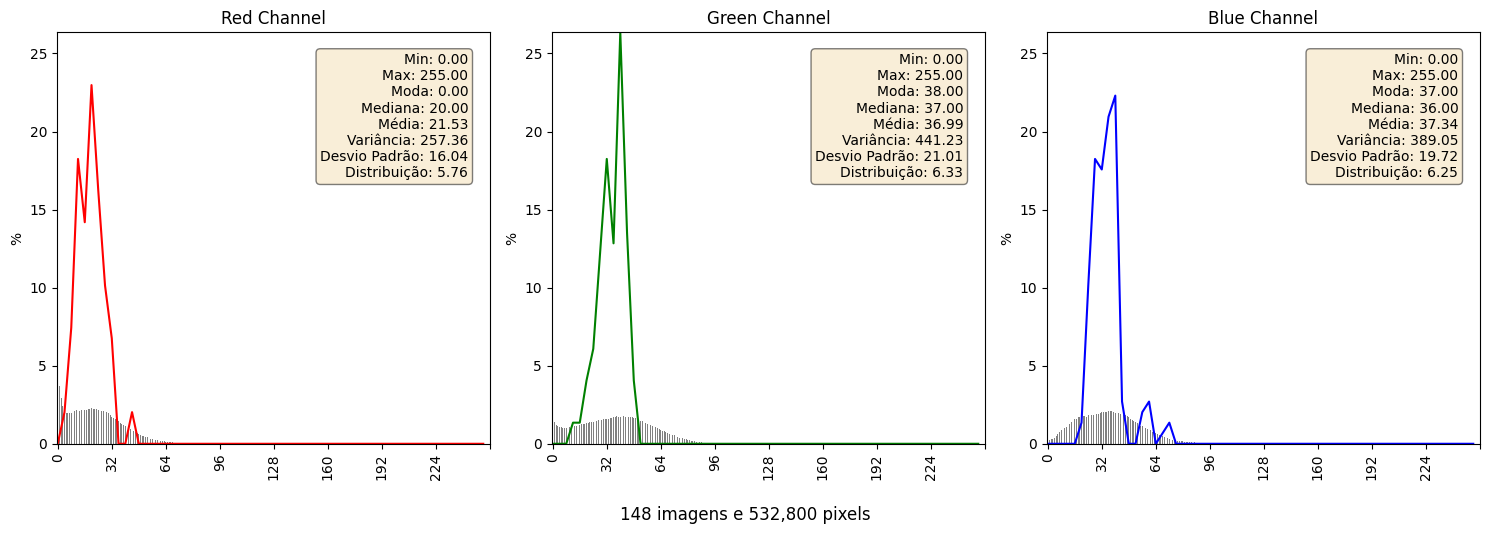

água


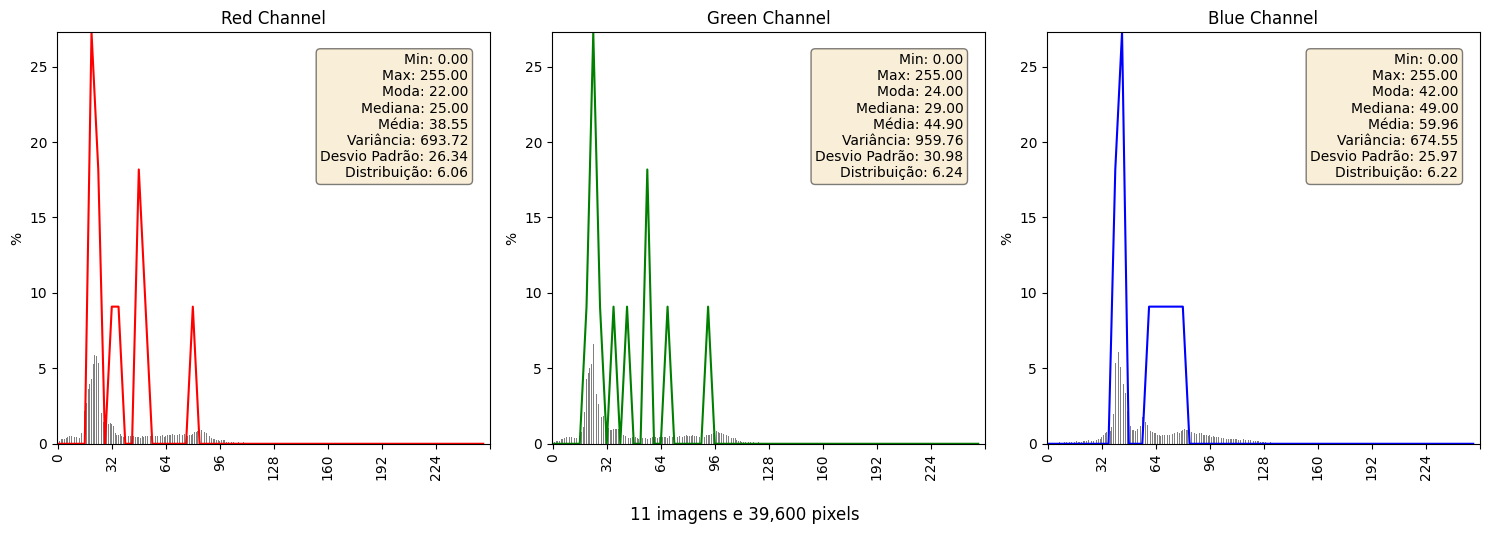

estrada


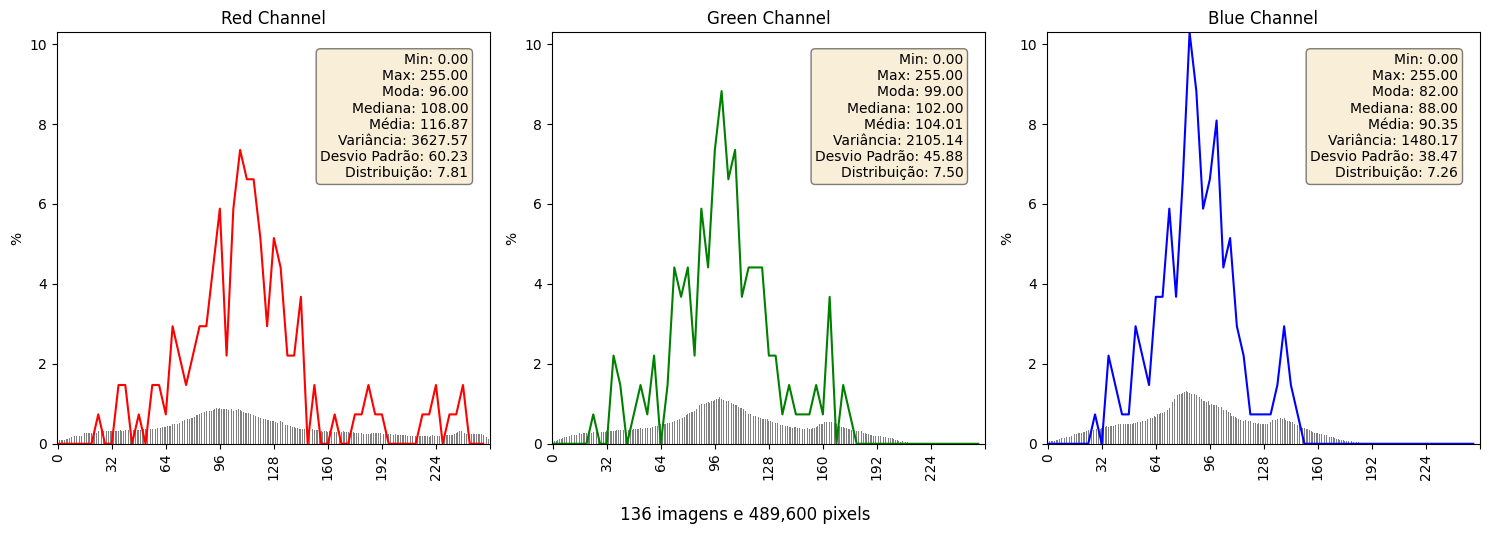

construção


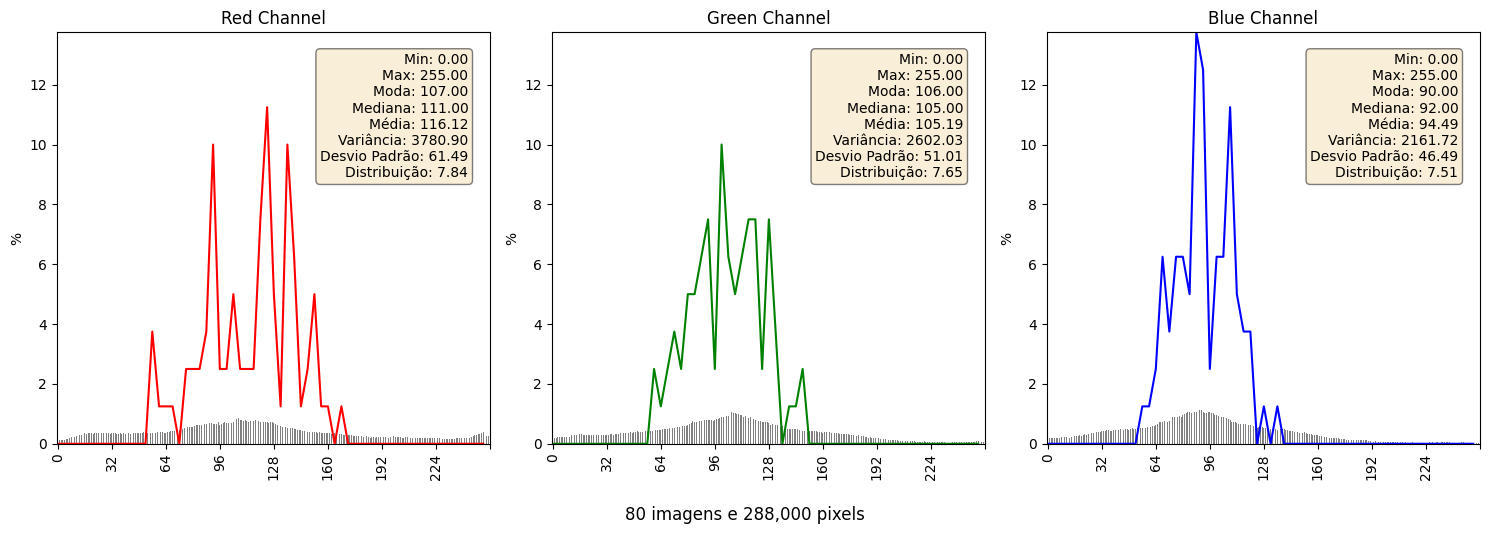

pasto


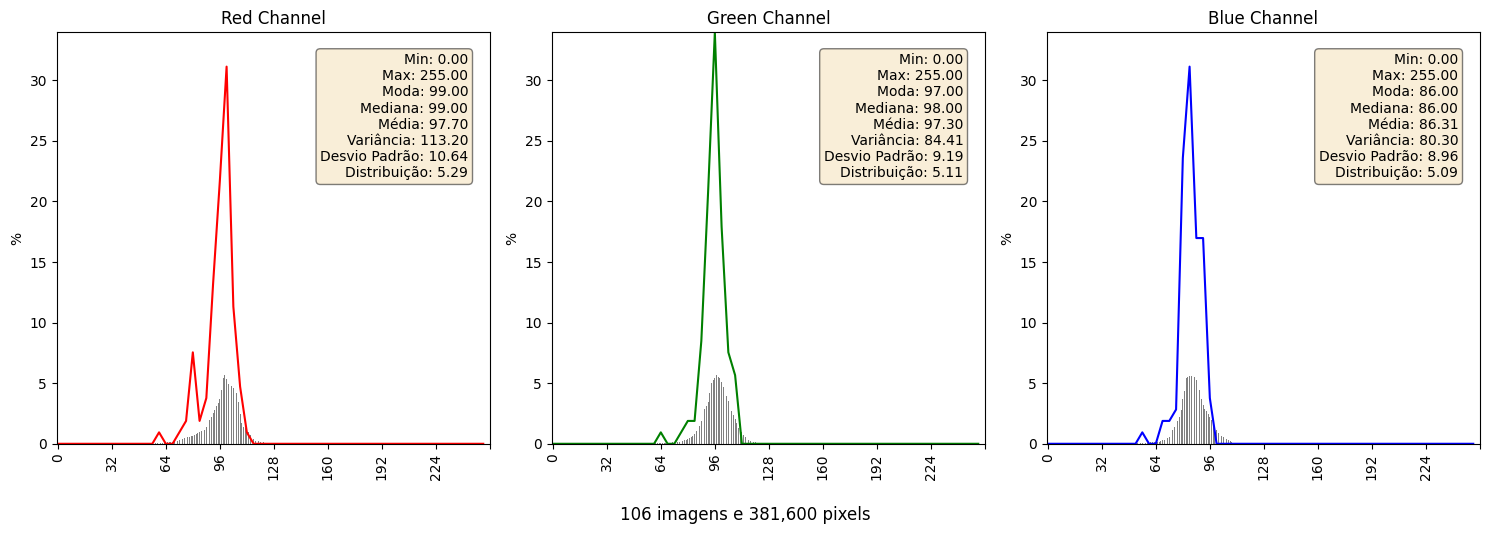

plantação


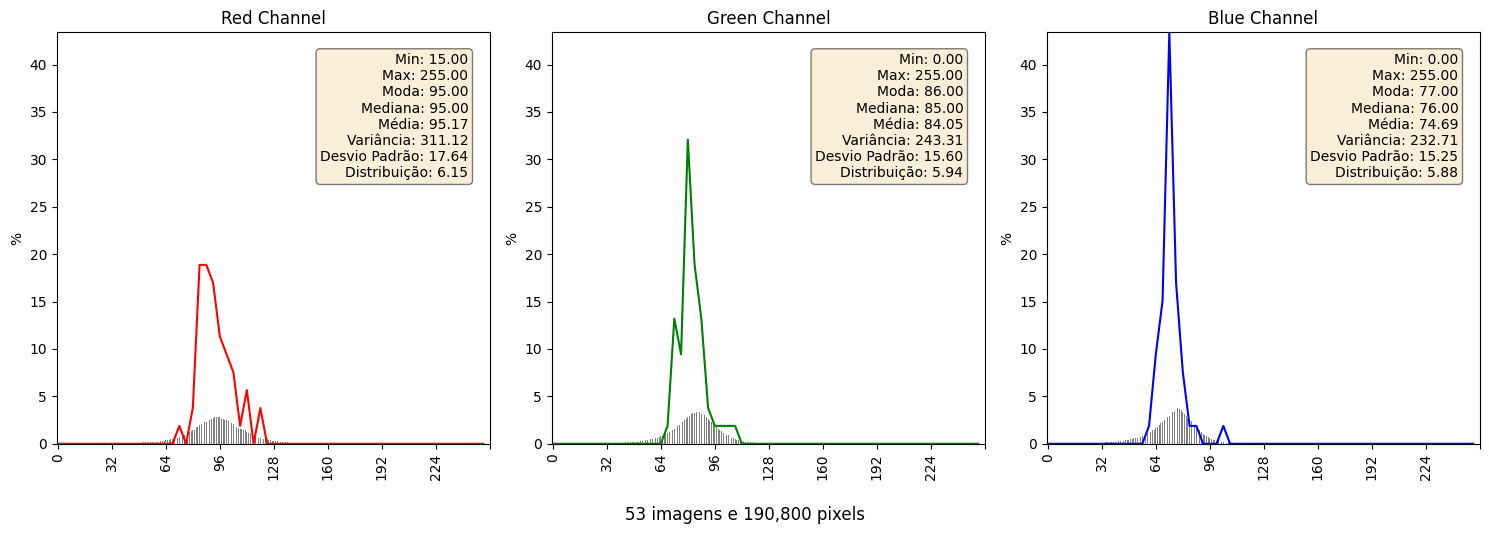

eucalipto


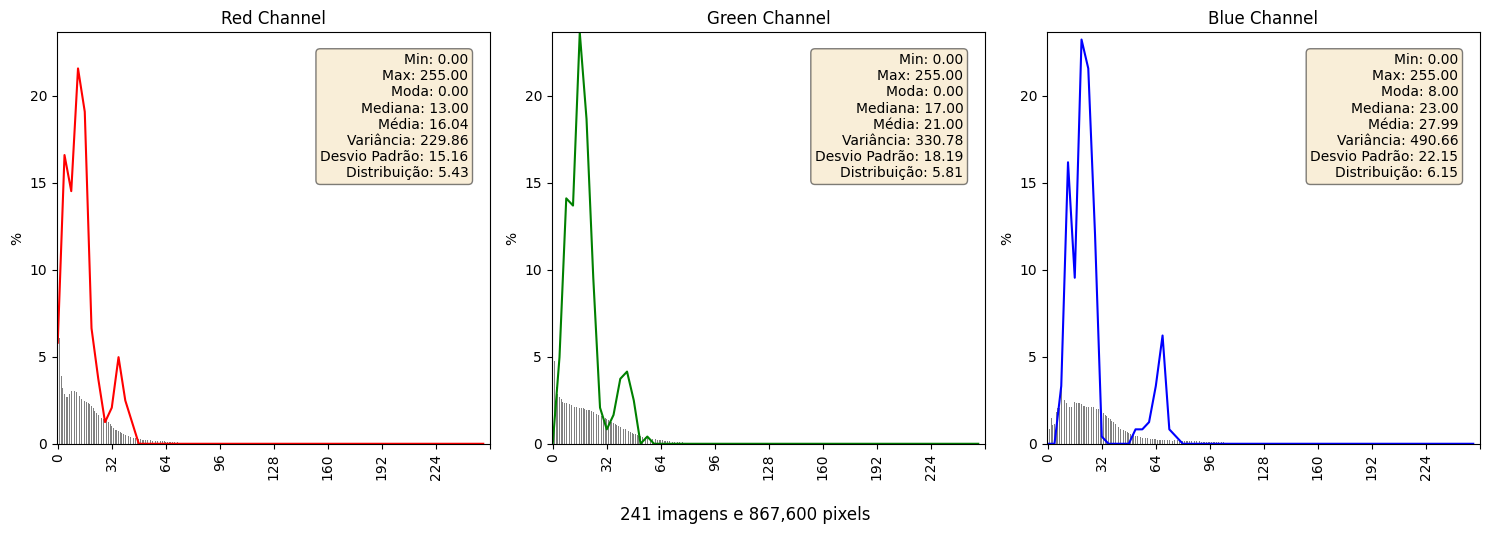

In [ ]:
for n in set.sets:
  print(n)
  set.data[n].plotData(True)

Sets de água, construção e estrada mostraram abranger valores diversos de cores e não podem ser identificados apenas pela coloração do pixel. Isso se deve ao fato de serem objetos que não ocupam na totalidade a imagem e terem a presença de outros elementos. Por exemplo: imagens de estrada contém floresta as margens ou pasto, assim como um lago pode estar cercado de terra, floresta ou pasto.

A área de plantação selecionada no set têm plantas em estágio inicial e se vê mais a terra do que as plantas em si, por isso as cores são mais claras e a distribuição se equipara mais com a de pastagem do que com a de uma área com vegetação.

Floresta


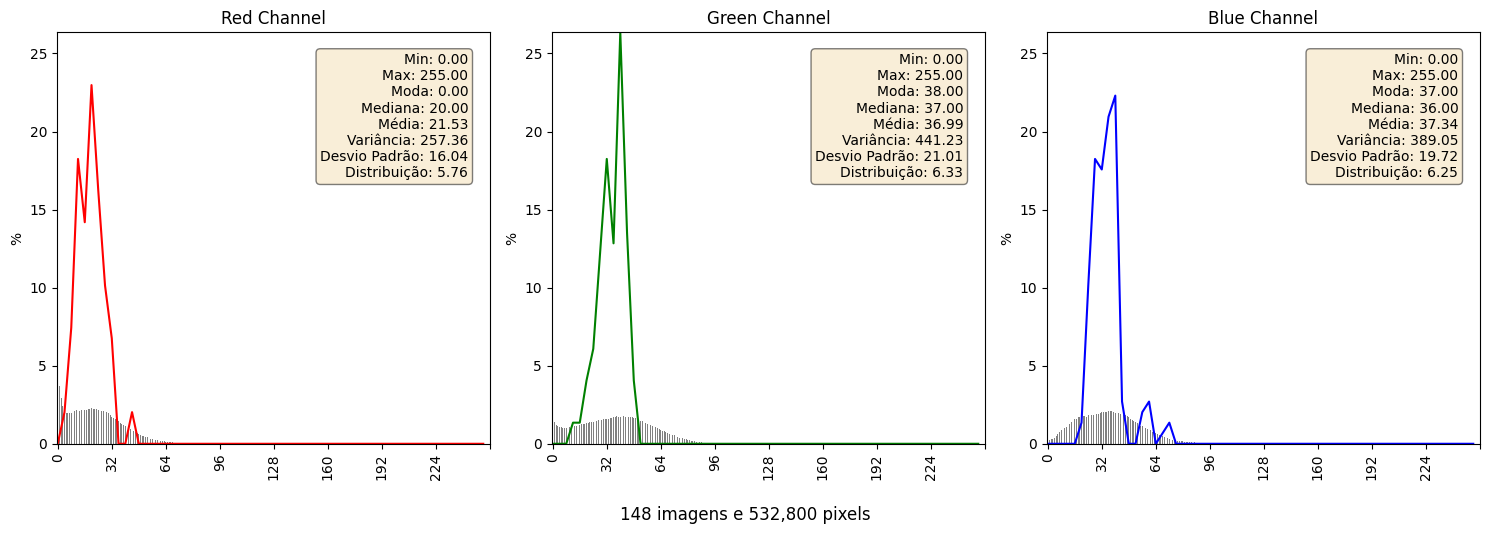

Plantação


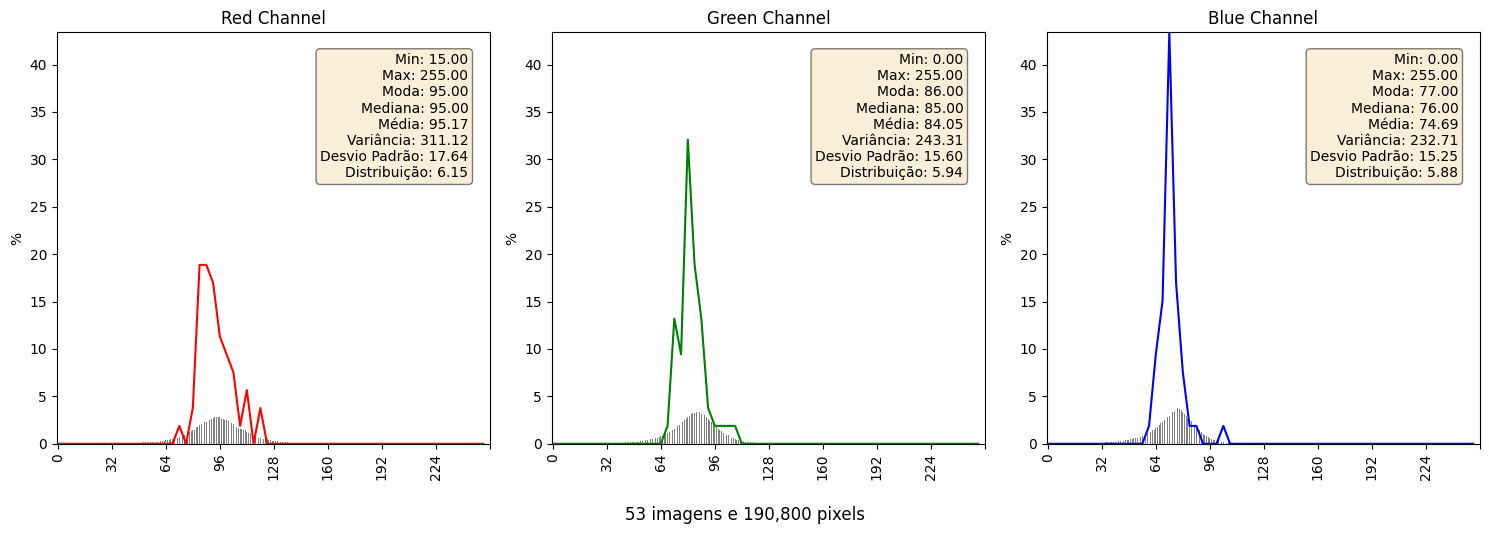

Pasto


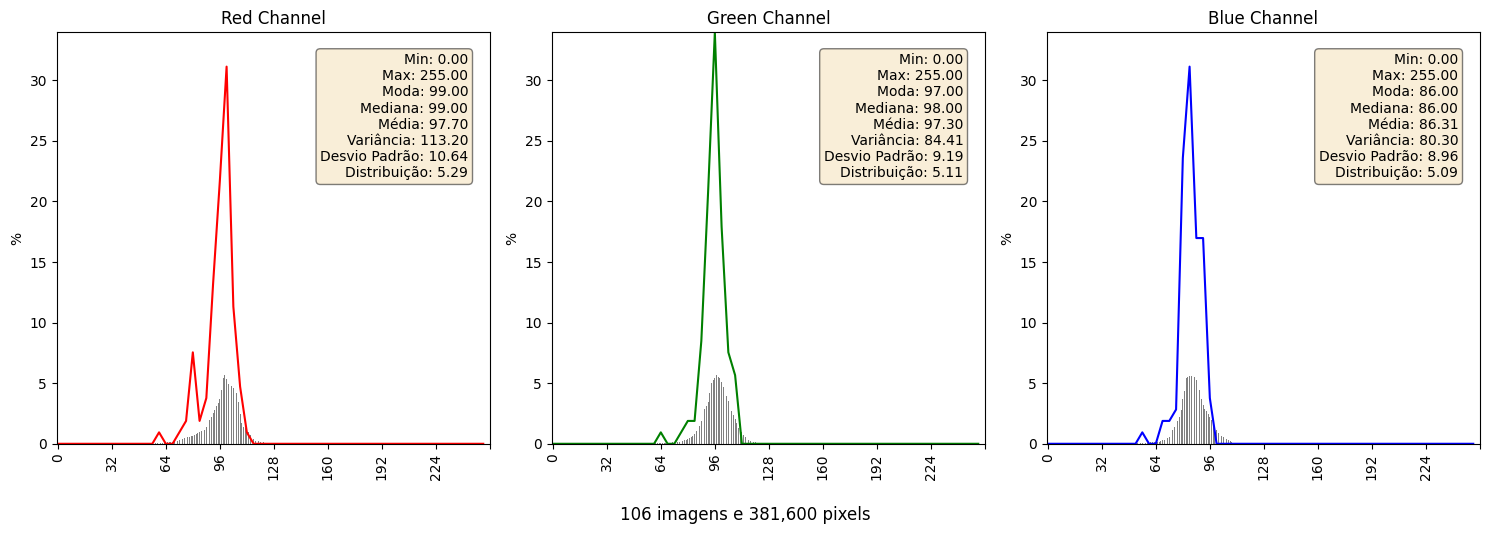

In [ ]:
print("Floresta")
set.data['floresta'].plotData(True)
print("Plantação")
set.data['plantação'].plotData(True)
print("Pasto")
set.data['pasto'].plotData(True)

A partir da exploração inicial definimos que poderiamos focar em dois sets específicos: o de floresta e o de pasto. Que são os mais presentes no mapa e são bons indicadores para definir se uma área se encontra com vegetação ou não.

Floresta


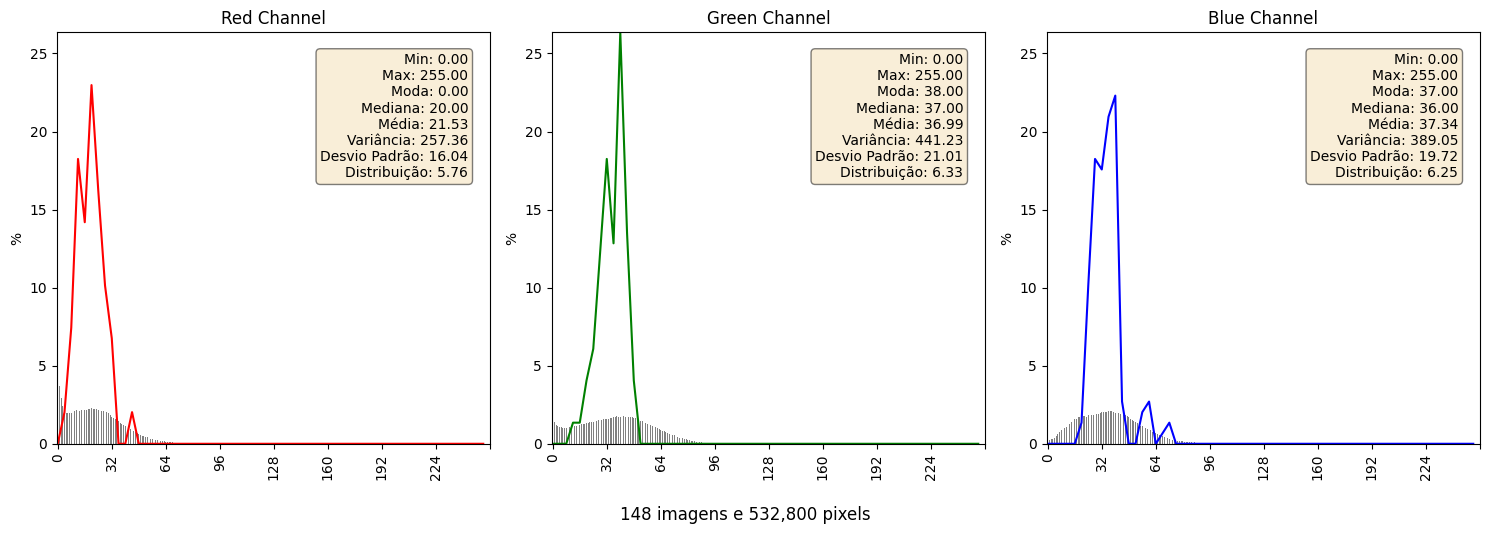

Pasto


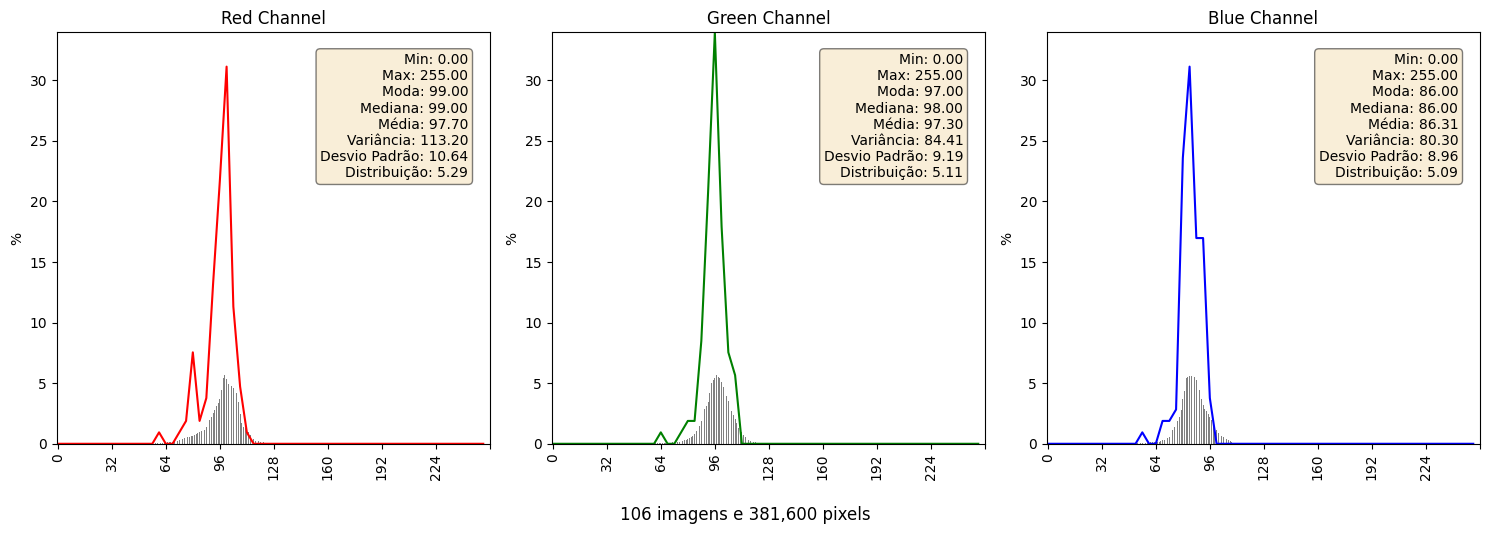

In [ ]:
print("Floresta")
set.data['floresta'].plotData(True)
print("Pasto")
set.data['pasto'].plotData(True)

Apesar dos sets acima serem bons indicadores, ainda existe uma intersecção do set de floresta com o set de eucalipto, que, apesar dos esforços, não será possível separar apenas com o estudo da distribuição de cores. Teremos que, com o maior número de amostras, usar um algorítmo de comparação de padrões na imagem, o qual deverá ser implementado como uma segunda camada de filtro após este primeiro que considera a distribuição de cores.

Floresta


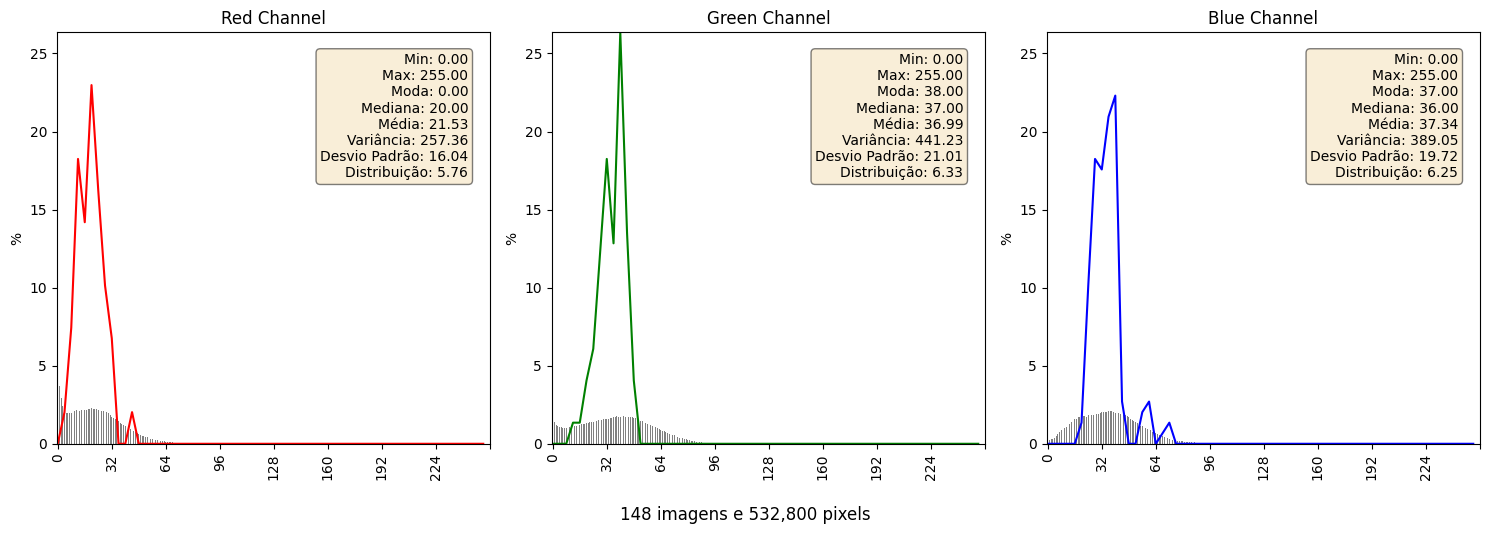

Eucalipto


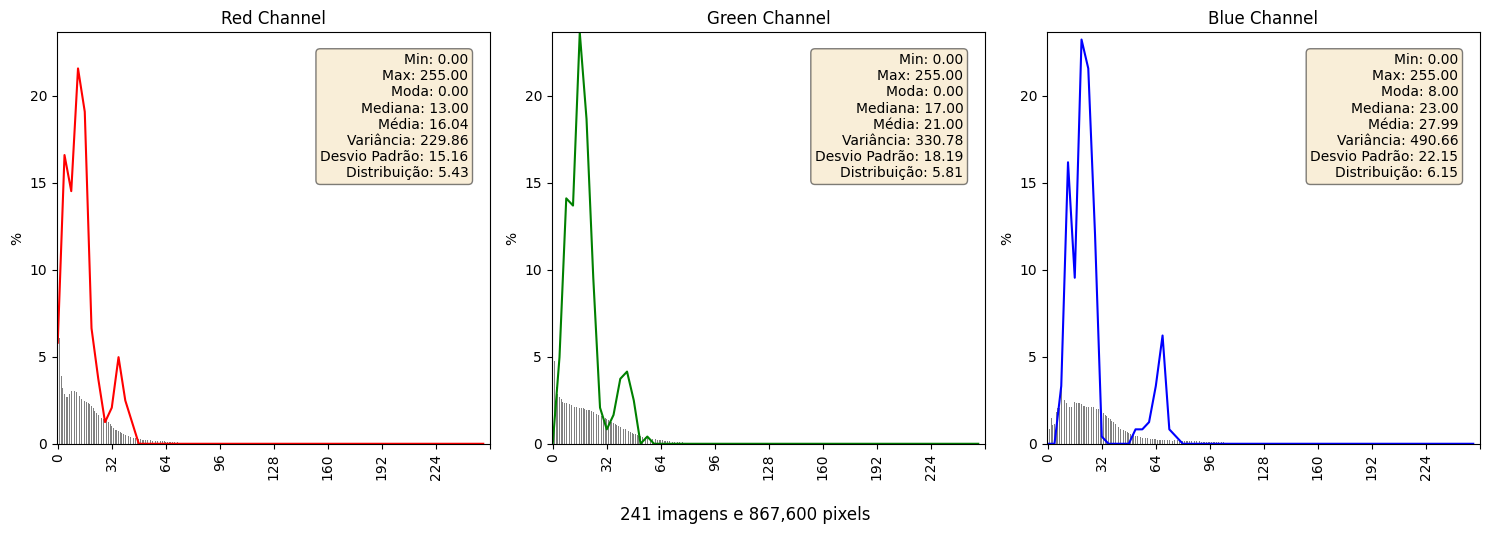

In [ ]:
print("Floresta")
set.data['floresta'].plotData(True)
print("Eucalipto")
set.data['eucalipto'].plotData(True)

Tentamos separar os sets usando a distribuição do canal verde, que no eucalípto forma um triângulo retângulo que decai a ocorrência de forma quase constante do 0 ao 64, aproximadamente. E a floresta tem sua maior incidência entre o 32 e o 64.

Floresta


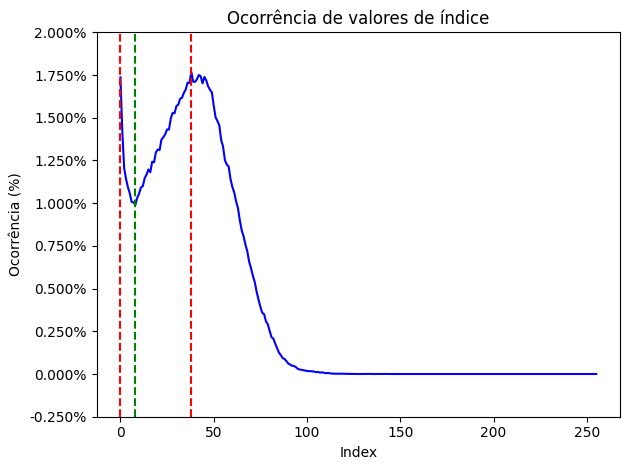

distance: 78.947%
delta: 0.778%
forest probability: 100.000%
floresta

Eucalipto


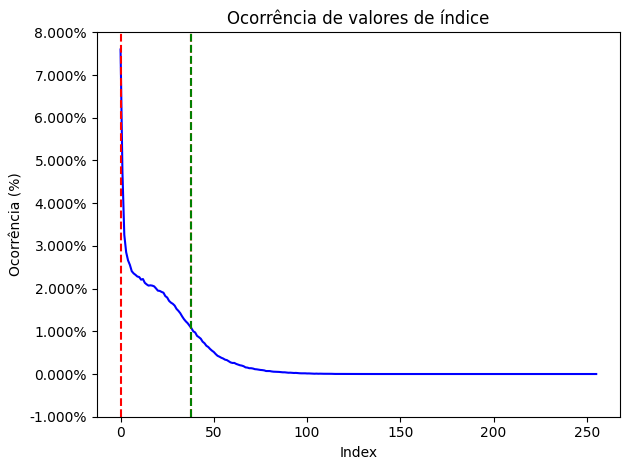

distance: 0.000%
delta: 0.000%
forest probability: 0.000%
eucalipto



In [ ]:
def plot_lista(entrada):
    if len(entrada) != 256:
        print("A lista deve conter 256 valores.")
        return

    # Normalizando os valores para representar porcentagens
    soma = sum(entrada)
    valores = [valor/soma for valor in entrada]

    # Convertendo a lista para um DataFrame do pandas
    df = pd.DataFrame(valores, columns=["Ocorrências"])

    # Plotando a curva
    ax = df.plot(color='blue', legend=False)
    plt.xlabel('Index')
    plt.ylabel('Ocorrência (%)')
    plt.title('Ocorrência de valores de índice')

    max_line=entrada.index(max(entrada))
    ax.axvline(x=max_line, color='red', linestyle='--')

    # Modificar as labels do eixo y para mostrar em porcentagem com três casas decimais
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)  # Definindo as localizações dos ticks
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}%".format(x*100)))  # Formatar ticks

    plt.tight_layout()
    plt.show()
    print(f"max_line: {max_line}\n")

def maxInBetween(list_, start, end):
  max_value=-np.inf
  max_ind=False
  for n in range(start, end):
    if list_[n]>max_value:
      max_value=list_[n]
      max_ind=n
  return max_ind

def minInBetween(list_, start, end):
  min_value=np.inf
  min_ind=False
  for n in range(start, end):
    if list_[n]<min_value:
      min_value=list_[n]
      min_ind=n
  return min_ind

def plot_lista2(entrada):
    if len(entrada) != 256:
        print("A lista deve conter 256 valores.")
        return

    # Normalizando os valores para representar porcentagens
    soma = sum(entrada)
    valores = [valor/soma for valor in entrada]

    # Convertendo a lista para um DataFrame do pandas
    df = pd.DataFrame(valores, columns=["Ocorrências"])

    # Plotando a curva
    ax = df.plot(color='blue', legend=False)
    plt.xlabel('Index')
    plt.ylabel('Ocorrência (%)')
    plt.title('Ocorrência de valores de índice')

    max_line_1=0 #maxInBetween(entrada,0,8)
    ax.axvline(x=max_line_1, color='red', linestyle='--')

    max_line_2=38 #maxInBetween(entrada,8,256)
    ax.axvline(x=max_line_2, color='red', linestyle='--')

    min_line=minInBetween(entrada, max_line_1, max_line_2+1) #entrada.index(min(entrada[:max_line_2]))
    ax.axvline(x=min_line, color='green', linestyle='--')

    # Modificar as labels do eixo y para mostrar em porcentagem com três casas decimais
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)  # Definindo as localizações dos ticks
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}%".format(x*100)))  # Formatar ticks

    plt.tight_layout()
    plt.show()

    v1=(max_line_2-min_line)/(max_line_2-max_line_1)
    v2=valores[max_line_2]-valores[min_line]
    v3=(v1*100/78.947)*(v2*100**2/77.797)
    if v3>0.5:
      v4='floresta'
    else:
      v4='eucalipto'
    print(f"distance: {100*v1:.3f}%\ndelta: {100*v2:.3f}%\nforest probability: {v3*100:.3f}%\n{v4}\n")

# Exemplo de uso
print('Floresta')
plot_lista2(set.data['floresta'].data['G'])
print('Eucalipto')
plot_lista2(set.data['eucalipto'].data['G'])

Apesar de esse padrão de ser uma constante queda na ocorrência para eucalipto e de cair a ocorrência e cuminar novamente para floresta. Essa tendencia só se mostrou presente na média e, ao executar o algorítimo em cada imagem de eucalipto e floresta, os resultados não foram promissores.

In [ ]:
def forest_prob(entrada): # Criamos uma função que retorna a probabilidade de ser floresta baseado na análise acima
    if len(entrada) != 256:
        print("A lista deve conter 256 valores.")
        return

    # Normalizando os valores para representar porcentagens
    soma = sum(entrada)
    valores = [valor/soma for valor in entrada]

    max_line_1=0
    max_line_2=38
    min_line=minInBetween(entrada, max_line_1, max_line_2+1)

    v1=(max_line_2-min_line)/(max_line_2-max_line_1)
    v2=valores[max_line_2]-valores[min_line]
    v3=(v1*100/78.947)*(v2*100**2/77.797)
    if v3>0.5:
      v4='floresta'
    else:
      v4='eucalipto'

    return {"distance": v1, "delta": v2, "forest_prob": v3, "guess": v4}

# Vamos executar o teste para cada imagem do set de floresta e de eucalipto

test_floresta=[]
for n in set.data['floresta'].data['images']:
  test_floresta.append(forest_prob(n['G']))

test_eucalipto=[]
for n in set.data['floresta'].data['images']:
  test_eucalipto.append(forest_prob(n['G']))

# Vamos transformar a lista de dicionários em um dicionário de listas:

def merge_dicts(dict_list):
    merged_dict = {}

    for d in dict_list:
        for key, value in d.items():
            if key not in merged_dict:
                merged_dict[key] = []
            merged_dict[key].append(value)

    return merged_dict

test_floresta=merge_dicts(test_floresta)
test_eucalipto=merge_dicts(test_eucalipto)

# Agora vamos fazer o print dos acertos para cada set

print("Acertividade usando o método:")
print(f"Floresta: {100*test_floresta['guess'].count('floresta')/len(test_floresta['guess']):.3f}%")
print(f"Eucalipto: {100*test_eucalipto['guess'].count('eucalipto')/len(test_eucalipto['guess']):.3f}%")

Acertividade usando o método:
Floresta: 79.730%
Eucalipto: 20.270%


Apesar do alto acerto para identificar áreas de floresta, 79.73%, apenas um quinto das áreas de eucalípto foram identificadas corretamente. Desta forma o método de teste da distribuição do canal verde se mostrou ineficiente para uso.

Para entender melhor, fizemos o plot de algumas imagens de cada set. Desta forma confirmamos que esse distribuição que percebemos só se mostra clara na média, mas impossível de identificar em imagens individuais.

No set de florestas:

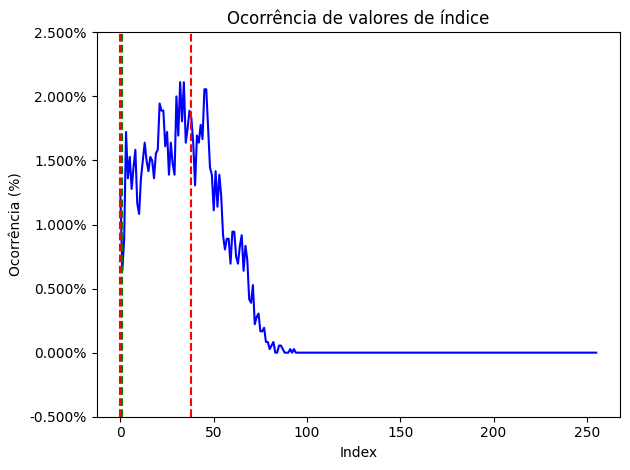

distance: 97.368%
delta: 1.194%
forest probability: 189.359%
floresta



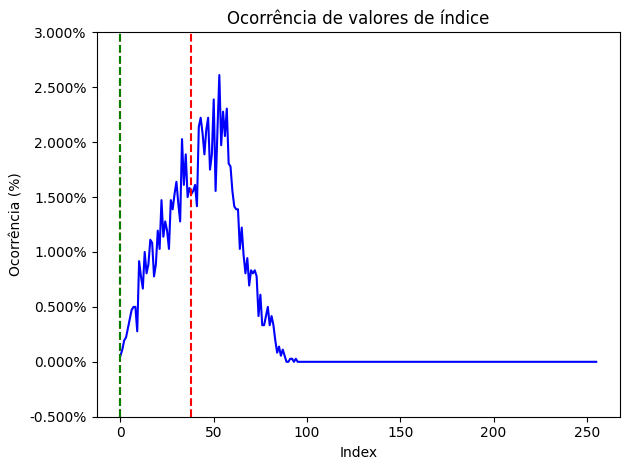

distance: 100.000%
delta: 1.472%
forest probability: 239.704%
floresta



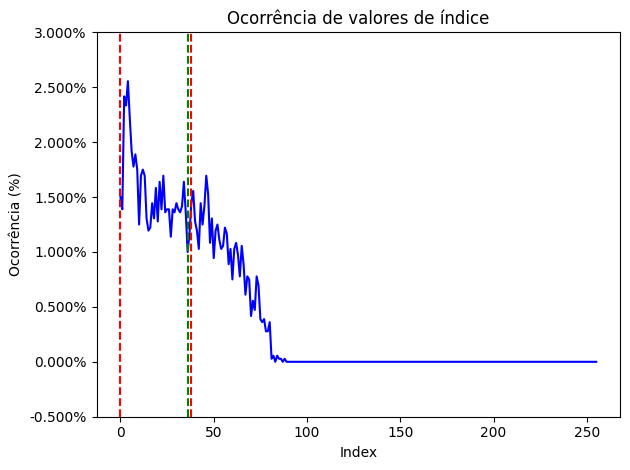

distance: 5.263%
delta: 0.444%
forest probability: 3.809%
eucalipto



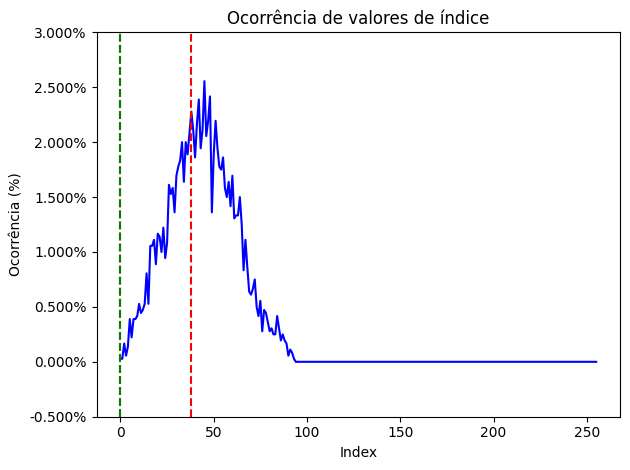

distance: 100.000%
delta: 2.250%
forest probability: 366.340%
floresta



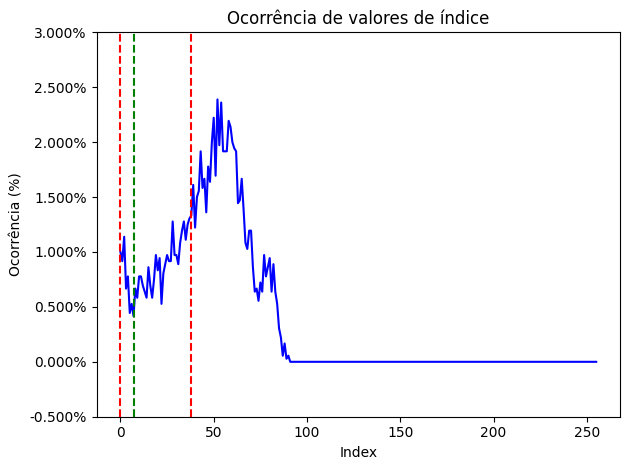

distance: 81.579%
delta: 0.917%
forest probability: 121.756%
floresta



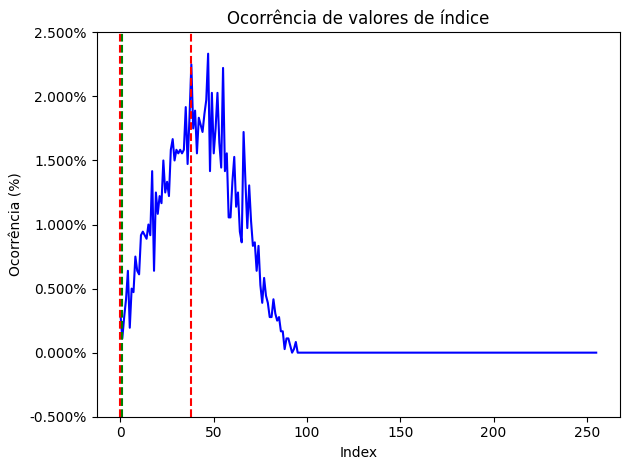

distance: 97.368%
delta: 2.139%
forest probability: 339.084%
floresta



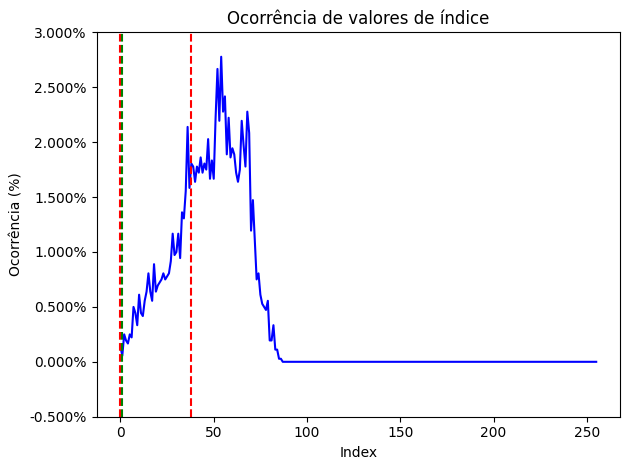

distance: 97.368%
delta: 1.750%
forest probability: 277.433%
floresta



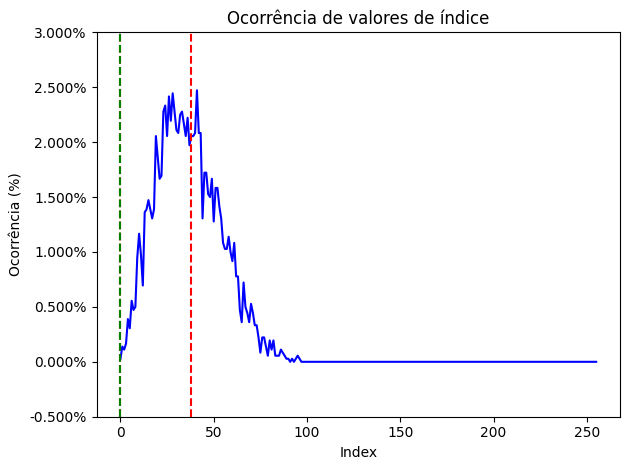

distance: 100.000%
delta: 2.028%
forest probability: 330.158%
floresta



In [ ]:
i=0
for n in set.data['floresta'].data['images']:
  if i%20==0:
    plot_lista2(n['G'])
  i+=1

No set de eucalipto:

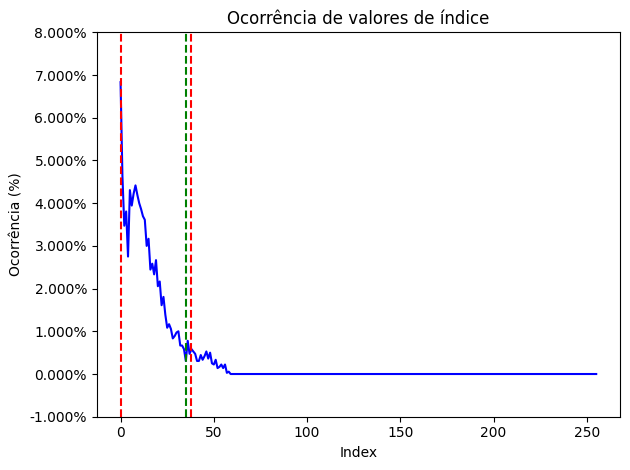

distance: 7.895%
delta: 0.278%
forest probability: 3.571%
eucalipto



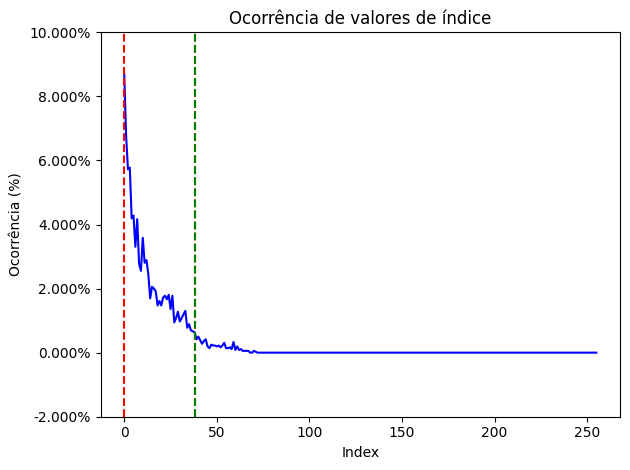

distance: 0.000%
delta: 0.000%
forest probability: 0.000%
eucalipto



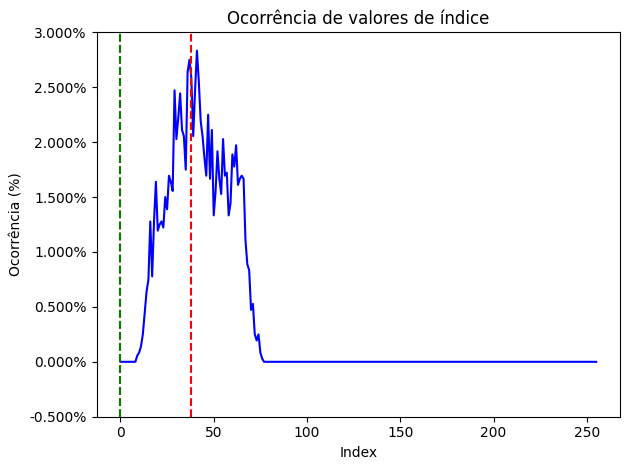

distance: 100.000%
delta: 2.583%
forest probability: 420.612%
floresta



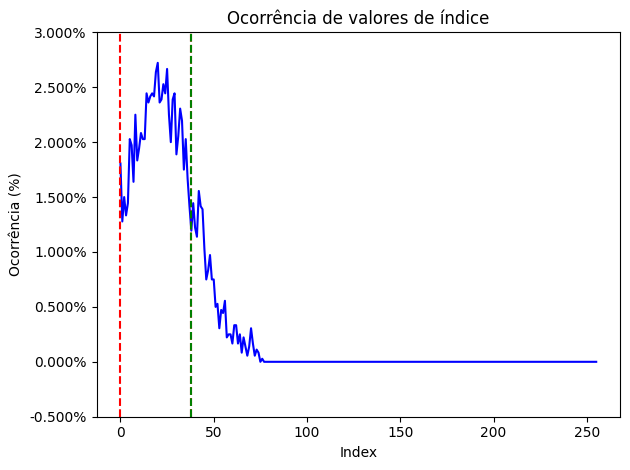

distance: 0.000%
delta: 0.000%
forest probability: 0.000%
eucalipto



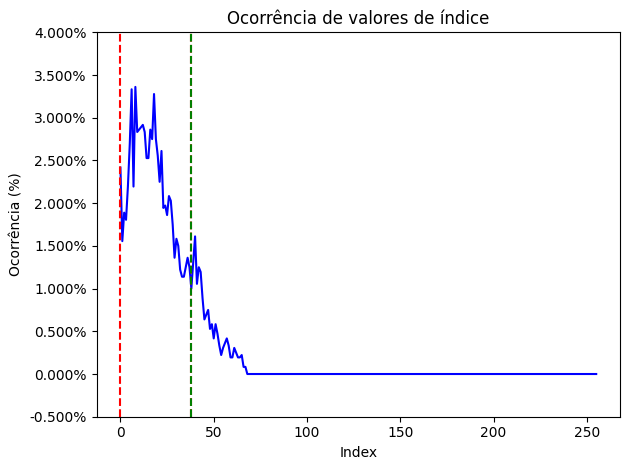

distance: 0.000%
delta: 0.000%
forest probability: 0.000%
eucalipto



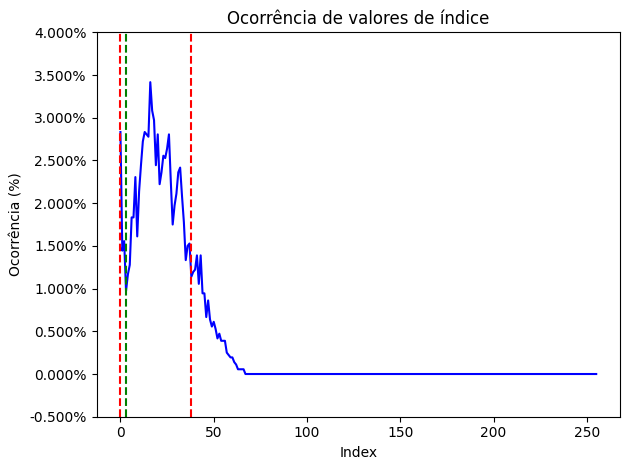

distance: 92.105%
delta: 0.167%
forest probability: 24.994%
eucalipto



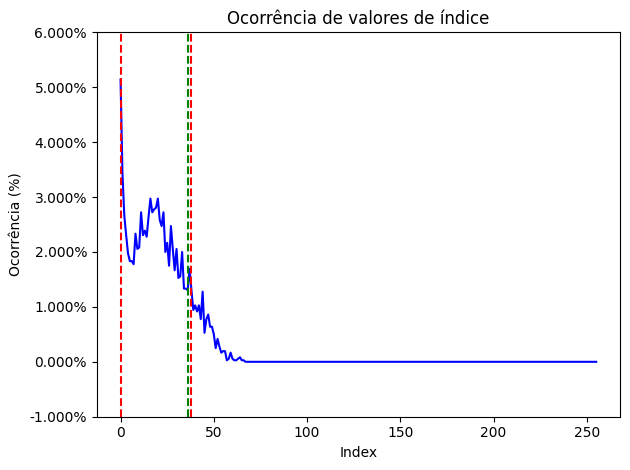

distance: 5.263%
delta: 0.000%
forest probability: 0.000%
eucalipto



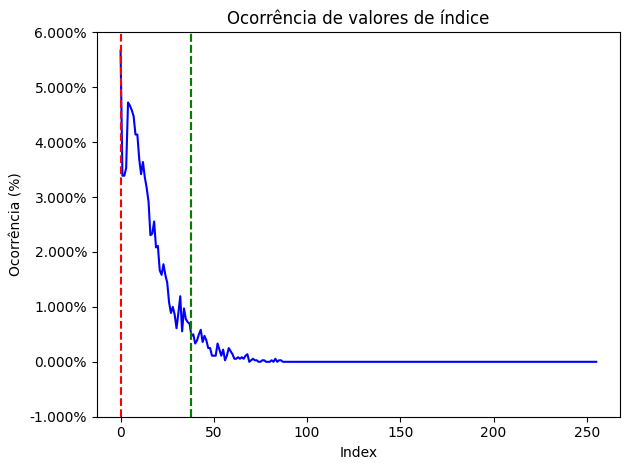

distance: 0.000%
delta: 0.000%
forest probability: 0.000%
eucalipto



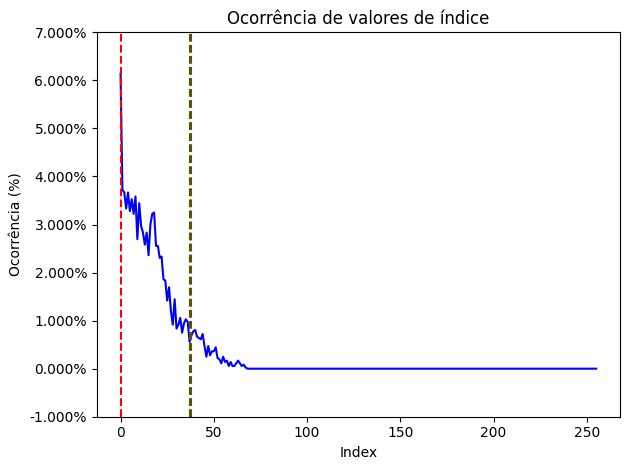

distance: 2.632%
delta: 0.139%
forest probability: 0.595%
eucalipto



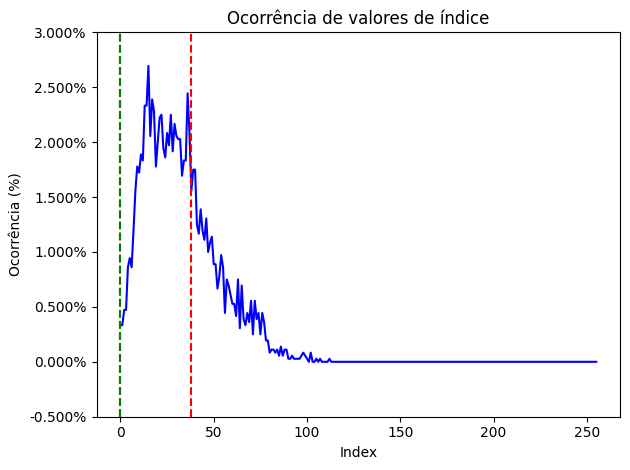

distance: 100.000%
delta: 1.222%
forest probability: 198.999%
floresta



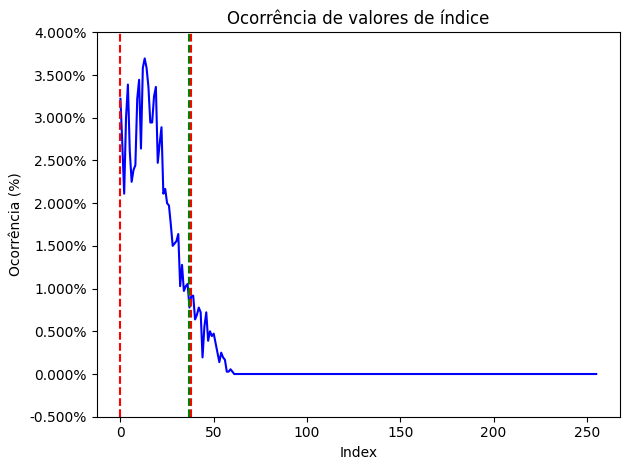

distance: 2.632%
delta: 0.139%
forest probability: 0.595%
eucalipto



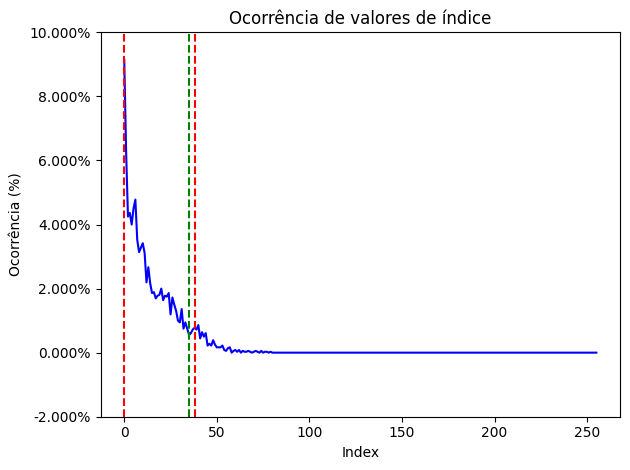

distance: 7.895%
delta: 0.222%
forest probability: 2.856%
eucalipto



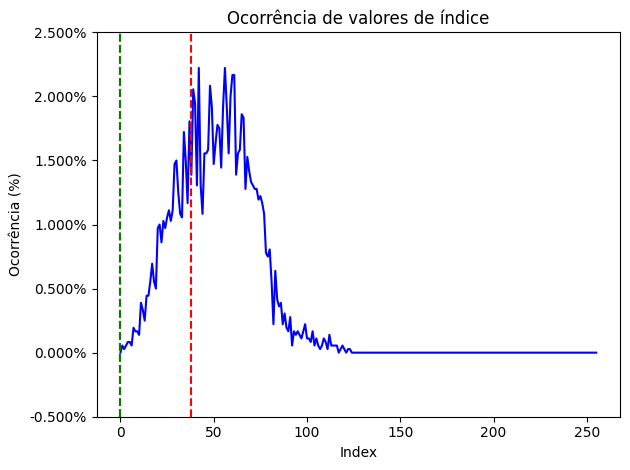

distance: 100.000%
delta: 1.389%
forest probability: 226.136%
floresta



In [ ]:
i=0
for n in set.data['eucalipto'].data['images']:
  if i%20==0:
    plot_lista2(n['G'])
  i+=1

Como não pudemos separar eucalipto e floresta por distribuição de cores, voltaremos o foco a fazer a distinção principal: pastagem de floresta. Para isso juntaremos os sets a ser comparados em um gráfico.

In [ ]:
def plot_lista3(set1, set2, canal):
    entrada1 = set.data[set1].data[canal]
    entrada2 = set.data[set2].data[canal]

    if len(entrada1) != 256 or len(entrada2) != 256:
        print("As listas devem conter 256 valores.")
        return

    # Normalizando os valores para representar porcentagens
    soma1 = sum(entrada1)
    valores1 = [valor/soma1 for valor in entrada1]

    soma2 = sum(entrada2)
    valores2 = [valor/soma2 for valor in entrada2]

    # Convertendo as listas para um DataFrame do pandas
    df = pd.DataFrame({
        'Ocorrências 1': valores1,
        'Ocorrências 2': valores2
    })

    # Plotando as curvas
    ax = df['Ocorrências 1'].plot(color='green', legend=True, label=set1)
    df['Ocorrências 2'].plot(color='red', ax=ax, legend=True, label=set2)
    plt.xlabel(f'Valor de {canal}')
    plt.ylabel('Ocorrência (%)')
    plt.title(f'Ocorrência de valores de canal {canal}')

    max_line1 = entrada1.index(max(entrada1))
    ax.axvline(x=max_line1, color='green', linestyle='--', label=f'Max {set1} (x={max_line1})')

    max_line2 = entrada2.index(max(entrada2))
    ax.axvline(x=max_line2, color='red', linestyle='--', label=f'Max {set2} (x={max_line2})')

    cut_line=0
    for n in range(0,256):
      if valores1[n]==valores2[n]:
        cut_line=n
        break;
      elif valores1[n]<valores2[n]:
        cut_line=n-0.5
        break;

    ax.axvline(x=cut_line, color='blue', linestyle='--', label=f'Linha de corte (x={cut_line})')

    # Modificar as labels do eixo y para mostrar em porcentagem com três casas decimais
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)  # Definindo as localizações dos ticks
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}%".format(x*100)))  # Formatar ticks

    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

Faremos o plot da comparação de cada canal e abaixo a média por imagem máxima do canal para floresta e a mínima para eucalipto.

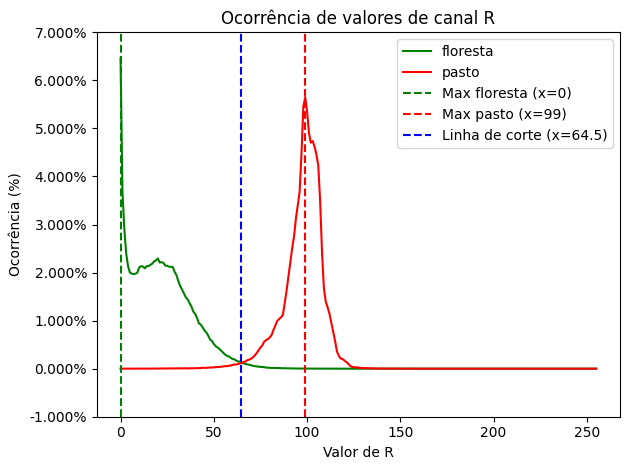

floresta max : 46.09027777777778 <> 63.72555555555556 : pasto min


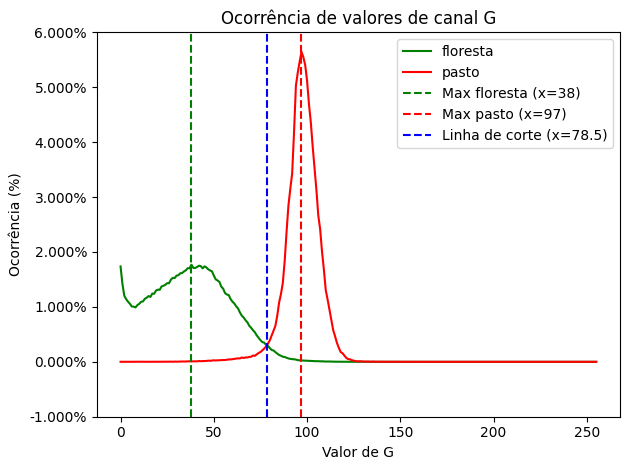

floresta max : 50.06388888888889 <> 65.33583333333333 : pasto min


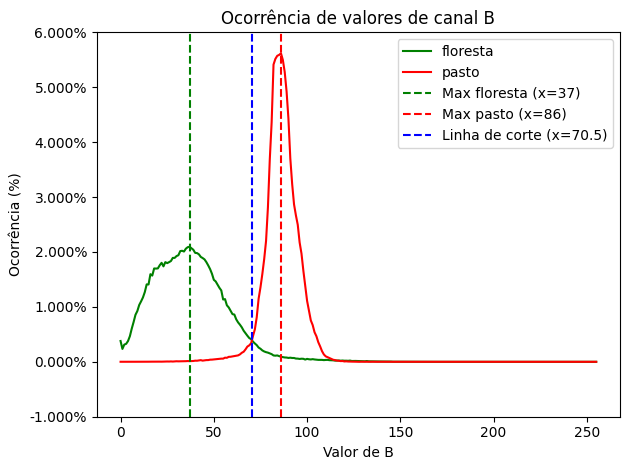

floresta max : 73.9036111111111 <> 57.834722222222226 : pasto min


In [ ]:
plot_lista3('floresta','pasto','R')
print(f"floresta max : {max(set.data['floresta'].data['R_med'])} <> {min(set.data['pasto'].data['R_med'])} : pasto min")
plot_lista3('floresta','pasto','G')
print(f"floresta max : {max(set.data['floresta'].data['G_med'])} <> {min(set.data['pasto'].data['G_med'])} : pasto min")
plot_lista3('floresta','pasto','B')
print(f"floresta max : {max(set.data['floresta'].data['B_med'])} <> {min(set.data['pasto'].data['B_med'])} : pasto min")

Para melhorar a visualização, fizemos o gráfico comparativo. Nesta versão, em cada valor dividimos o número de ocorrências em um set pela soma das ocorrências nos dois. Se não houver nenhuma ocorrências no valor ambos recebem 50%, evitando uma divisão por zero.

In [ ]:
def plot_lista4(set1, set2, canal, clear=False):
    entrada1 = set.data[set1].data[canal]
    entrada2 = set.data[set2].data[canal]

    if len(entrada1) != 256 or len(entrada2) != 256:
        print("As listas devem conter 256 valores.")
        return

    # Normalizando os valores para representar porcentagens
    soma1 = sum(entrada1)
    valoresA1 = [valor/soma1 for valor in entrada1]

    soma2 = sum(entrada2)
    valoresA2 = [valor/soma2 for valor in entrada2]

    valores1=[]
    valores2=[]
    for n in range(0,256):
      soma=valoresA1[n]+valoresA2[n]
      if soma==0:
        valores1.append(0.5)
        valores2.append(0.5)
      else:
        valores1.append(valoresA1[n]/soma)
        valores2.append(valoresA2[n]/soma)

    cut_line=0
    for n in range(0,256):
      if valores1[n]==valores2[n]:
        cut_line=n
        break;
      elif valores1[n]<valores2[n]:
        cut_line=n-0.5
        break;

    max_line1 = 256-maxInBetween(valores1[::-1],255-round(cut_line), 256)
    max_line2 = maxInBetween(valores2, round(cut_line), 256)

    if clear:
      for n in range(max_line2,256):
        valores1[n]=0
        valores2[n]=1

    # Convertendo as listas para um DataFrame do pandas
    df = pd.DataFrame({
        'Probabilidade 1': valores1,
        'Probabilidade 2': valores2
    })

    # Plotando as curvas
    ax = df['Probabilidade 1'].plot(color='green', legend=True, label=set1)
    df['Probabilidade 2'].plot(color='red', ax=ax, legend=True, label=set2)
    plt.xlabel(f'Valor de {canal}')
    plt.ylabel('Probabilidade (%)')
    plt.title(f'Probabilidade pelo canal {canal}')

    ax.axvline(x=max_line1, color='green', linestyle='--', label=f'Max {set1} (x={max_line1})')
    ax.axvline(x=max_line2, color='red', linestyle='--', label=f'Max {set2} (x={max_line2})')

    ax.axvline(x=cut_line, color='blue', linestyle='--', label=f'Linha de corte (x={cut_line})')

    # Modificar as labels do eixo y para mostrar em porcentagem com três casas decimais
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)  # Definindo as localizações dos ticks
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}%".format(x*100)))  # Formatar ticks

    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

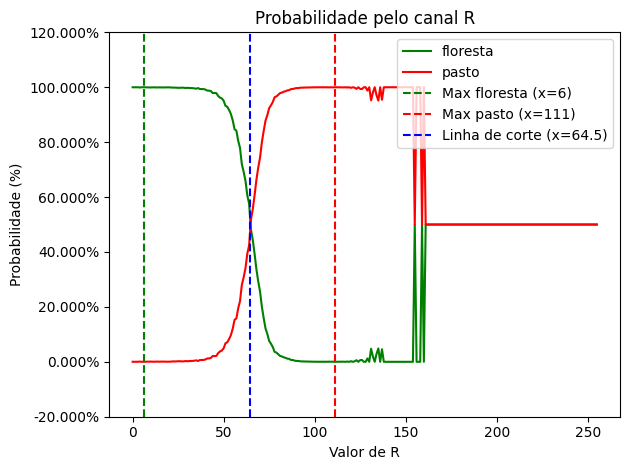

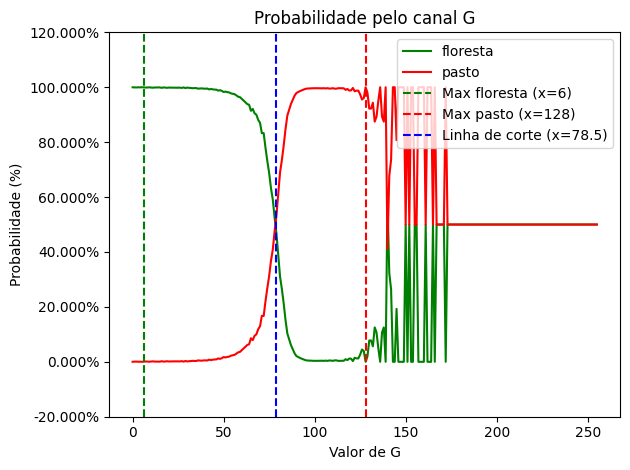

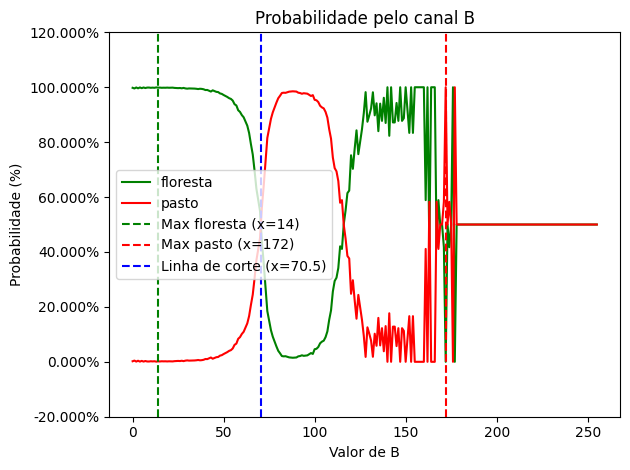

In [ ]:
plot_lista4('floresta','pasto','R')
plot_lista4('floresta','pasto','G')
plot_lista4('floresta','pasto','B')

Escolhemos o canal R para usarmos nesta primeira camada de filtragem. Pois - apesar de ser semelhante ao canal G - ele tem um espaçamento maior entre as médias e medianas dos diferentes sets, além de - para floresta - a distribuição, a variância e o desvio padrão serem menores. Desta forma o canal R é ideal para encontrarmos distinguirmos com alta  acertividade uma zona com vegetação e sem vegetação.

Veja novamente os gráficos para estes sets:

Floresta


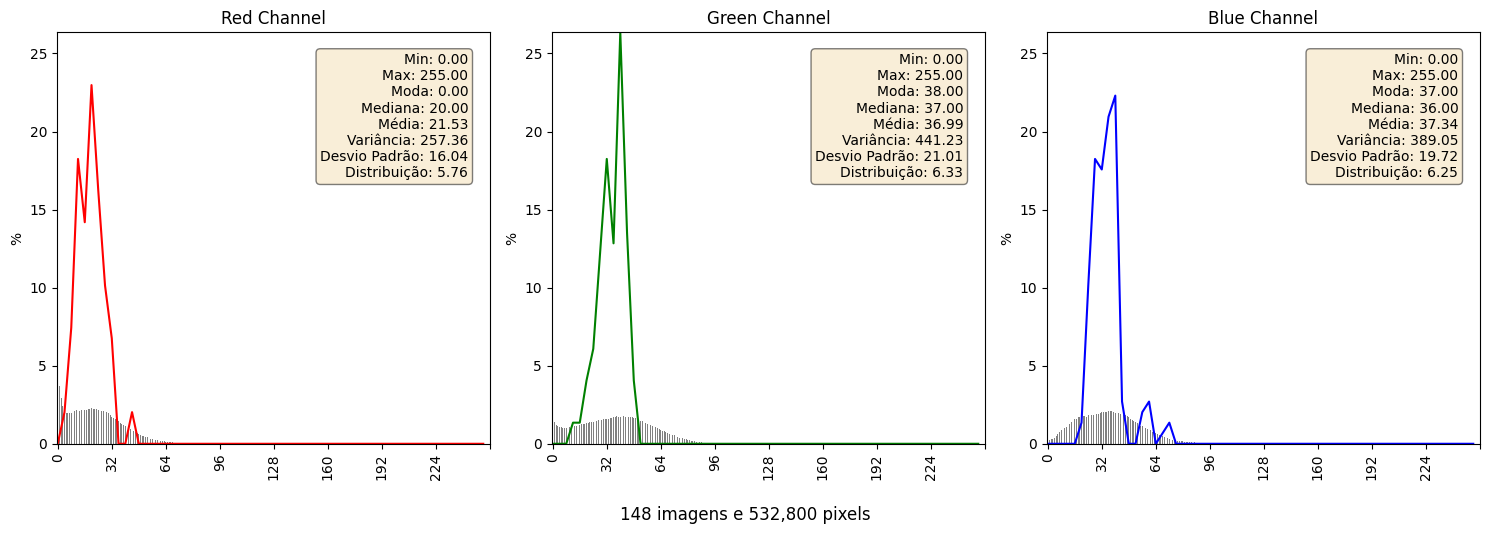

Pasto


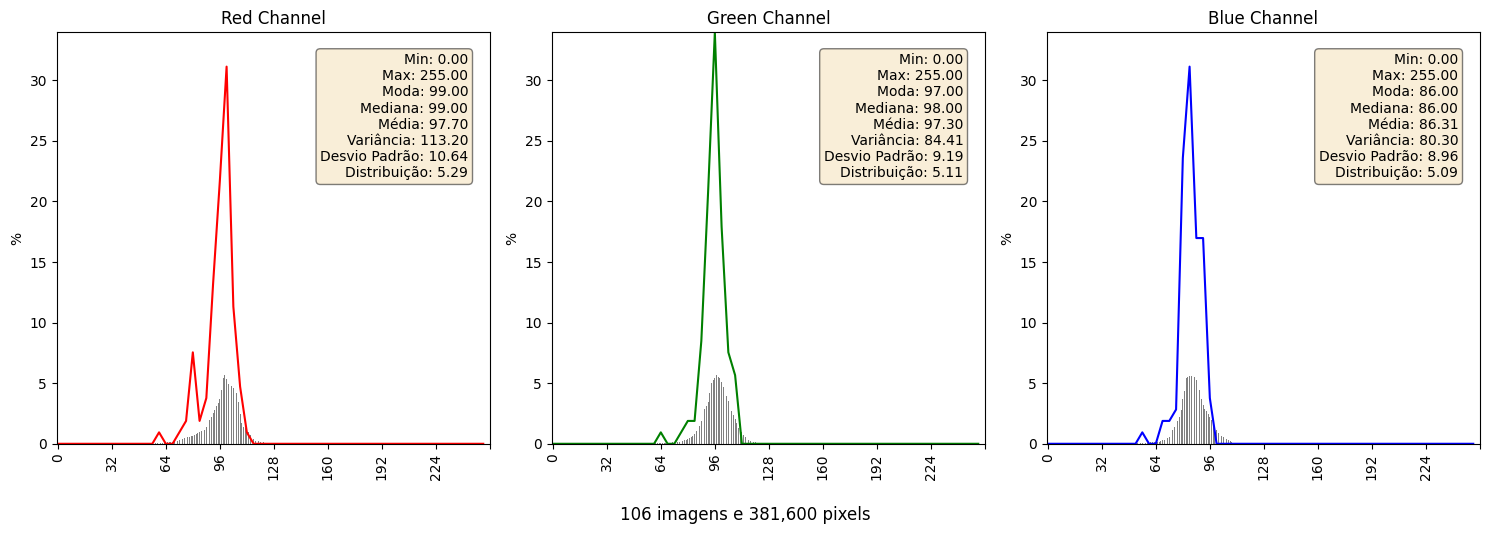

In [ ]:
print("Floresta")
set.data['floresta'].plotData(True)
print("Pasto")
set.data['pasto'].plotData(True)

Elaboramos uma variação da função *plot_lista4* que nos traga os dados de forma mais limpa. Para esta nova função, apenas podemos alterar a sensibilidade que já é por padrão 99.5%. Nesta nova função se normaliza para 100% floresta, tudo que está abaixo da primeira ocorrência de 99.5% floresta da linha de corte para o zero. E, se normaliza para pasto tudo que está após a primeira ocorrência de 99.5% de pasto após a linha de corte.

In [ ]:
def plot_lista5(sens=0.995):
    set1='floresta'
    set2='pasto'
    canal='R'
    entrada1 = set.data[set1].data[canal]
    entrada2 = set.data[set2].data[canal]

    if len(entrada1) != 256 or len(entrada2) != 256:
        print("As listas devem conter 256 valores.")
        return

    # Normalizando os valores para representar porcentagens
    soma1 = sum(entrada1)
    valoresA1 = [valor/soma1 for valor in entrada1]

    soma2 = sum(entrada2)
    valoresA2 = [valor/soma2 for valor in entrada2]

    valores1=[]
    valores2=[]
    for n in range(0,256):
      soma=valoresA1[n]+valoresA2[n]
      if soma==0:
        valores1.append(0.5)
        valores2.append(0.5)
      else:
        valores1.append(valoresA1[n]/soma)
        valores2.append(valoresA2[n]/soma)

    cut_line=0
    for n in range(0,256):
      if valores1[n]==valores2[n]:
        cut_line=n
        break;
      elif valores1[n]<valores2[n]:
        cut_line=n-(valores2[n]-0.5)/(valores2[n]-valores1[n])
        break;

    max_line1 = 256-maxInBetween(valores1[::-1],255-round(cut_line), 256)
    for n in range(round(cut_line)-1,max_line1,-1):
      if valores1[n]>sens:
        max_line1 = n
        break;

    max_line2 = maxInBetween(valores2, round(cut_line), 256)
    for n in range(round(cut_line)+1,max_line2):
      if valores2[n]>sens:
        max_line2 = n
        break;

    for n in range(max_line1-1,-1,-1):
      valores1[n]=1
      valores2[n]=0

    for n in range(max_line2+1,256):
      valores1[n]=0
      valores2[n]=1

    # Convertendo as listas para um DataFrame do pandas
    df = pd.DataFrame({
        'Probabilidade 1': valores1,
        'Probabilidade 2': valores2
    })

    # Plotando as curvas
    ax = df['Probabilidade 1'].plot(color='green', legend=True, label=set1)
    df['Probabilidade 2'].plot(color='red', ax=ax, legend=True, label=set2)
    plt.xlabel(f'Valor de {canal}')
    plt.ylabel('Probabilidade (%)')
    plt.title(f'Probabilidade pelo canal {canal}')

    ax.axvline(x=max_line1, color='green', linestyle='--', label=f'Max {set1} (x={max_line1})')
    ax.axvline(x=max_line2, color='red', linestyle='--', label=f'Max {set2} (x={max_line2})')

    ax.axvline(x=cut_line, color='blue', linestyle='--', label=f'Linha de corte (x={cut_line:.1f})')

    # Modificar as labels do eixo y para mostrar em porcentagem com três casas decimais
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)  # Definindo as localizações dos ticks
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}%".format(x*100)))  # Formatar ticks

    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

    return {'floresta':valores1,'pasto':valores2,'max_floresta':max_line1,'max_pasto':max_line2,'corte':cut_line}

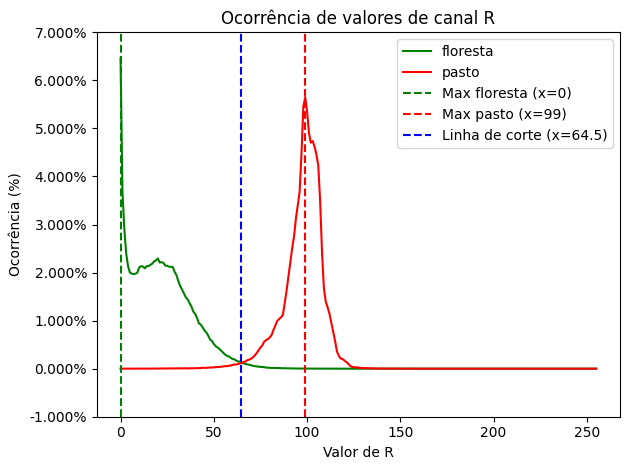

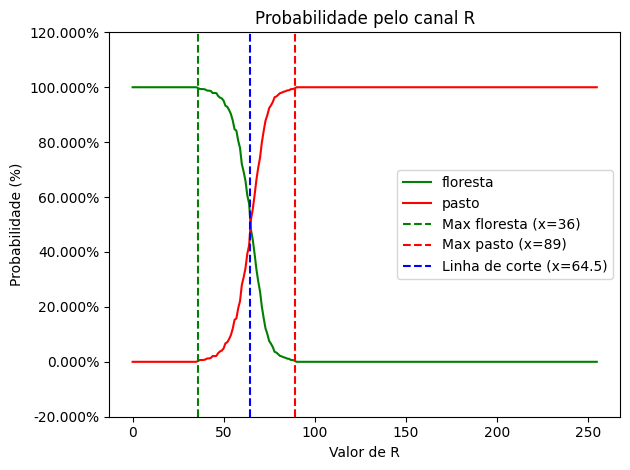

In [ ]:
plot_lista3('floresta','pasto','R')
resultado=plot_lista5()

Note que *plot_lista5* retorna um dicionário (salvo em **resultado**) que pode ser usado como referência para deduções sobre pixels ao trabalhar uma imagem.

Se quisermos saber a probabilidade de um pixel qualquer ser floresta ou pasto:


1.   Isolamos o valor do canal vermelho
2.   Lemos o valor em *resultado['floresta'][valor do canal vermelho]*

Assim teremos a probabilidade do pixel ser floresta. Ou lemos *resultado['pasto'][valor do canal vermelho]* se quisermos a probabilidade de ser pasto.





In [ ]:
print("**Para um pixel com R=47**\n")
print(f"Probabilidade de ser floresta: {100*resultado['floresta'][47]:.3f}%")
print(f"Probabilidade de ser pasto: {100*resultado['pasto'][47]:.3f}%")

**Para um pixel com R=47**

Probabilidade de ser floresta: 96.828%
Probabilidade de ser pasto: 3.172%


OBS: Note que a probabilidade de ser pasto é igual à 100% menos a probabilidade de ser floresta, e vice-versa.

In [ ]:
round(resultado['pasto'][47],3)==round(1-resultado['floresta'][47],3)

True

O método acima para encontrar vegetação usando o canal vermelho foi aplicado nas imagens e mostrou excelentes resultados. Sendo assim, será o método utilizado pelo projeto para identificar a preservação (ou não) das áreas de nascentes e margens de rios.